In [12]:
import os
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [21]:
def get_model(pretrained=True):
    model = maskrcnn_resnet50_fpn_v2(pretrained=pretrained)
    return model
COCO_CLASSES = [
    "__background__", "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
    "traffic light", "fire hydrant", "N/A", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse",
    "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "N/A", "backpack", "umbrella", "N/A", "N/A",
    "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove",
    "skateboard", "surfboard", "tennis racket", "bottle", "N/A", "wine glass", "cup", "fork", "knife", "spoon", "bowl",
    "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair",
    "couch", "potted plant", "bed", "N/A", "dining table", "N/A", "N/A", "toilet", "N/A", "tv", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "N/A", "book", "clock",
    "vase", "scissors", "teddy bear", "hair drier", "toothbrush"
]

In [38]:
def process_image(image_path, model, device, confidence_threshold=0.5):
    image = Image.open(image_path).convert("RGB")
    image_tensor = F.to_tensor(image).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        predictions = model(image_tensor)

    pred = predictions[0]
    masks = pred['masks'][pred['scores'] > confidence_threshold]
    boxes = pred['boxes'][pred['scores'] > confidence_threshold]
    labels = pred['labels'][pred['scores'] > confidence_threshold]
    scores = pred['scores'][pred['scores'] > confidence_threshold]
    
    return image, masks, boxes, labels, scores

In [40]:
def visualize_detections(image, masks, boxes, labels, scores):
    plt.figure(figsize=(12, 8))
    img_np = np.array(image)
    
    colors = np.random.randint(0, 255, (len(masks), 3))
    
    overlay = img_np.copy()
    
    for i in range(len(masks)):
        mask = masks[i, 0].cpu().numpy()
        color = colors[i]

        overlay[mask > 0.5] = overlay[mask > 0.5] * 0.7 + color * 0.3

        box = boxes[i].cpu().numpy()

        plt.plot([box[0], box[2], box[2], box[0], box[0]],
                [box[1], box[1], box[3], box[3], box[1]],
                color=[c/255 for c in color],
                linewidth=2)
        label = COCO_CLASSES[labels[i].item()]
        score = scores[i].item()
        plt.text(box[0], box[1] - 5,
                f'{label}: {score:.2f}',
                bbox=dict(facecolor=[c/255 for c in color], alpha=1),
                color='white',
                fontsize=8)
    
    plt.imshow(overlay)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = get_model(pretrained=True)
model.to(device)
model.eval()
image_path = r'data\dinner.webp'  

Using device: cpu


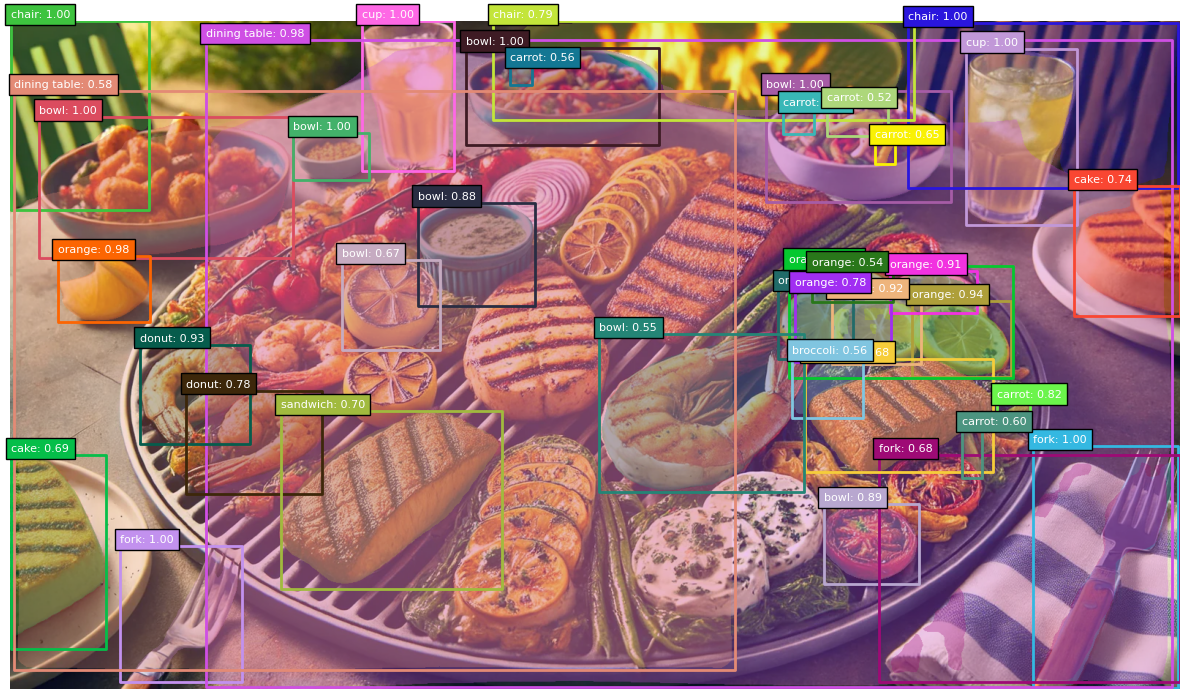


Detected objects:
- cup: 1.00
- chair: 1.00
- fork: 1.00
- bowl: 1.00
- bowl: 1.00
- cup: 1.00
- bowl: 1.00
- fork: 1.00
- bowl: 1.00
- chair: 1.00
- dining table: 0.98
- orange: 0.98
- orange: 0.94
- donut: 0.93
- orange: 0.92
- orange: 0.91
- bowl: 0.89
- bowl: 0.88
- orange: 0.86
- carrot: 0.82
- chair: 0.79
- donut: 0.78
- orange: 0.78
- cake: 0.74
- sandwich: 0.70
- cake: 0.69
- fork: 0.68
- sandwich: 0.68
- bowl: 0.67
- carrot: 0.65
- carrot: 0.60
- carrot: 0.60
- orange: 0.59
- dining table: 0.58
- broccoli: 0.56
- carrot: 0.56
- bowl: 0.55
- orange: 0.54
- carrot: 0.52


In [45]:
image, masks, boxes, labels, scores = process_image(image_path, model, device)
visualize_detections(image, masks, boxes, labels, scores)

print("\nDetected objects:")
for i in range(len(labels)):
    label = COCO_CLASSES[labels[i].item()]
    score = scores[i].item()
    print(f"- {label}: {score:.2f}")
